# Document Clustering and Topic Modeling

In this project, I used unsupervised learning models to cluster unlabeled documents into different groups, visualized the results, and identified their latent topics/structures.

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
* [Part 6: Discussion](#Part-6:-Discussion)

# Part 1: Load Data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import nltk
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import LatentDirichletAllocation

random.seed(20202200)

/Users/yanhans/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Load data into dataframe
df = pd.read_csv("Review_data.csv", sep=',', header=0)

In [3]:
df.head()

,review_body,star_rating
0,Good luck finding a reasonably priced band rep...,1
1,No i get dark on the first week with me!! I wi...,1
2,I dont know if mine was a mistake but it clear...,1
3,The rod that holds the bracelet broke several ...,1
4,"I bought 2 watches , one watch doesnot work at...",1


In [4]:
# Cheching if there is any missing value
df.isnull().sum()

review_body    0
star_rating    0
dtype: int64

In [5]:
df.star_rating.value_counts()

5    3000
4    3000
3    3000
2    3000
1    3000
Name: star_rating, dtype: int64

In [6]:
# Take only the review_body column for unsupervised learning task

data = df.loc[:, 'review_body'].tolist()
print(type(data))
print(len(data))

<class 'list'>
15000


In [7]:
# Take a look at some of the reviews
for _ in range(5):
    print(data[_],"\n")

Good luck finding a reasonably priced band replacement. I ordered the band from the dealer who sold it to me (no one else in town could get one) and Skagen sent the wrong one.  I guess I'll try again, but not allowing anyone else to make bands for your unique watch design seems stupid. I will certainly never buy one again. 

No i get dark on the first week with me!! I will never buy this item and i had buy 5 of them 

I dont know if mine was a mistake but it clearly states aqua so im confused why mine is lime green. I hate lime green and am very irritated. This is why people hate ordering on amazon. Ive spent 100s of dollars on here latey and this one will make me not want to order.  At least its not much money. Just annoying thinking u ordered something and get something else.  Well its going in the trash... 

The rod that holds the bracelet broke several times and the company do not fix it, it is sitting on the drawer so I can come to see the Jeweler to try to fix one more time. Don'

# Part 2: Tokenizing and Stemming

In [8]:
# Use nltk's English stopwords.
stopwords = stopwords.words('english')

print("We use " + str(len(stopwords)) + " stop-words from nltk library.")

We use 179 stop-words from nltk library.


Use our defined functions to analyze (i.e. tokenize, stem) our reviews.

In [9]:
def tokenization_and_stemming(text):
    '''
    INPUT
    text - string
    OUTPUT
    clean_tokens - a list of words
    This function processes the input using the following steps :
    1. Remove punctuation characters
    2. Tokenize text into list
    3. Stem, Normalize and Strip each word
    4. Remove stop words
    '''
    # Remove punctuation characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Create a instance of stem class
    stemmer = SnowballStemmer("english")
    
    clean_tokens = []
    for word in tokens:
        clean_tok = stemmer.stem(word).lower().strip()
        if clean_tok not in stopwords:
            clean_tokens.append(clean_tok)

    return clean_tokens

In [10]:
tokenization_and_stemming(data[42])

['warranti', 'card', 'box']

# Part 3: TF-IDF:Term Frequency-Inverse Document Frequency

In this part, I use the TfidfVectorizer() from the sklearn library to create the tf-idf matrix

In [11]:
tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : maximum document frequency for the given word
    max_features=1000, # max_features: maximum number of words
    min_df=0.01, # min_df : minimum document frequency for the given word
    use_idf=True, # use_idf: if not true, we only calculate tf
    tokenizer=tokenization_and_stemming,
    ngram_range=(1,1) # ngram_range: (min, max), eg. (1, 2) including 1-gram, 2-gram
)


# Fit the TfidfVectorizer to our data
tfidf_matrix = tfidf_model.fit_transform(data) 


print("In total, there are {} reviews and {} terms.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])
))

In total, there are 15000 reviews and 445 terms.


In [12]:
# Check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.99,
 'max_features': 1000,
 'min_df': 0.01,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [13]:
# Words
tf_selected_words = tfidf_model.get_feature_names()

In [14]:
tfidf_matrix

<15000x445 sparse matrix of type '<class 'numpy.float64'>'
	with 238491 stored elements in Compressed Sparse Row format>

# Part 4: K-means clustering

In this part, I perform the K-means algorithm to find out possible clusters in our reviews dataset. 

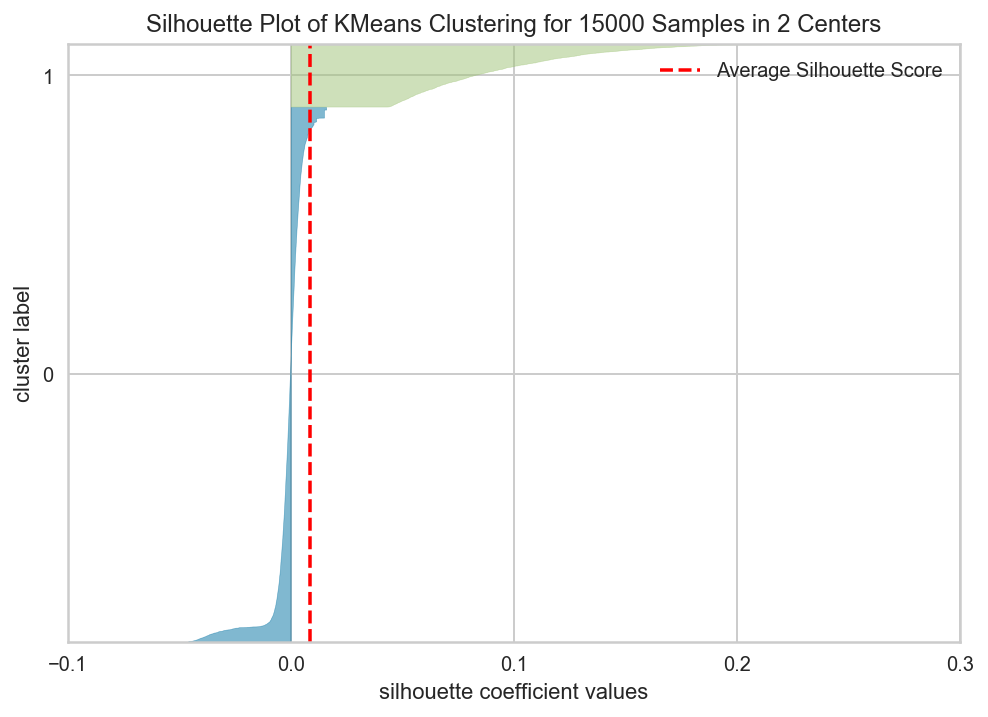

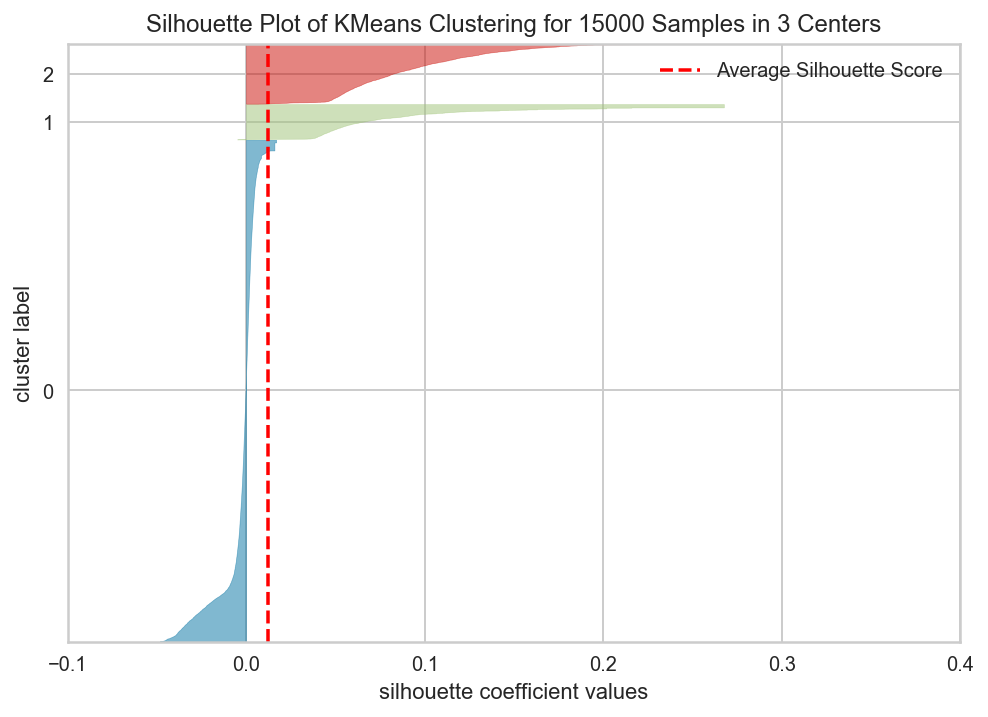

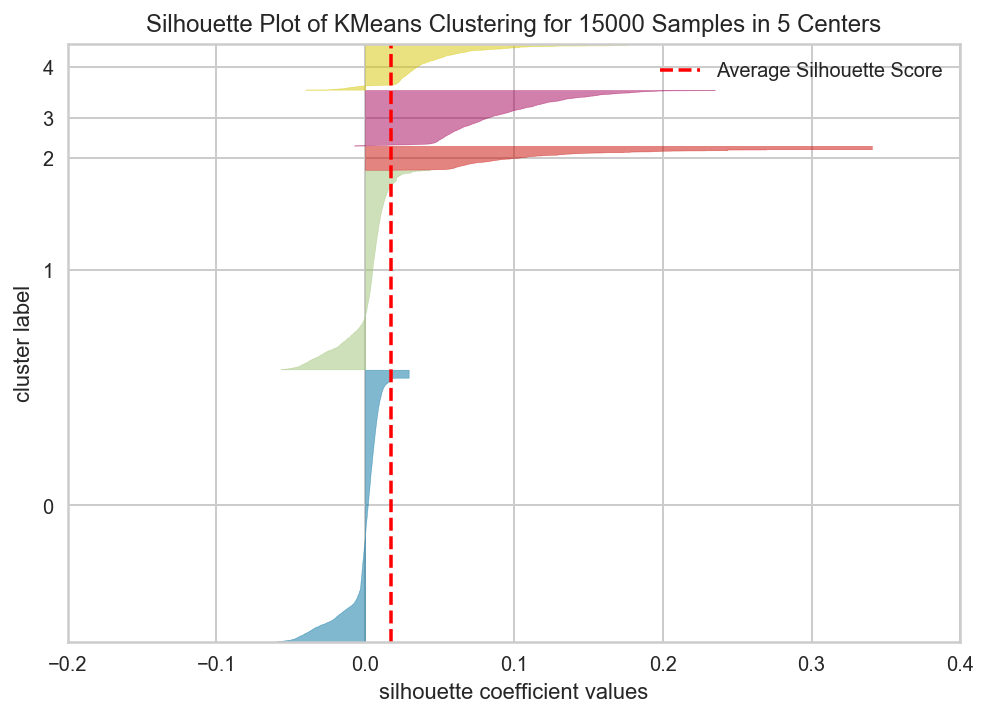

In [15]:
# Number of clusters
num_clusters = (2,3,5)

for num in num_clusters:
    kmeans = KMeans(n_clusters=num)

    model_km = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    model_km.fit(tfidf_matrix) # Fit the data to the visualizer
           
    model_km.show()

From the silhouette plot above, we can see the average silhouette coefficients are very similar among different solutions. There is no significant preference over one solution. As we know our dataset contains the product reviews, the reviews probably would fall into one of positive, neutral or negative clusters. So I decide to use 3 as the number of clusters in the kmeans.

In [16]:
kmeans_model = KMeans(n_clusters=3)

kmeans_model.fit(tfidf_matrix) # Fit the data

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 4.1. Analyze K-means Result

In [17]:
kmeans_results = df.rename({'review_body':'review'})
clusters = kmeans_model.labels_.tolist()
kmeans_results['cluster'] = clusters

In [18]:
kmeans_results.head(10)

,review_body,star_rating,cluster
0,Good luck finding a reasonably priced band rep...,1,0
1,No i get dark on the first week with me!! I wi...,1,0
2,I dont know if mine was a mistake but it clear...,1,0
3,The rod that holds the bracelet broke several ...,1,0
4,"I bought 2 watches , one watch doesnot work at...",1,0
5,"This watch would have been fantastic, if it ha...",1,0
6,I have this watch. It looks and feels heavy du...,1,0
7,What the hell! I just got the watch today but ...,1,0
8,I am mechanically inclined but cannot get this...,1,0
9,It didnt work right out from the box. I had to...,1,0


In [19]:
print ("Number of reviews included in each cluster:")
cluster_size = kmeans_results['cluster'].value_counts().to_frame()
cluster_size

Number of reviews included in each cluster:


,cluster
0,12612
1,1500
2,888


In [20]:
kmeans_results.groupby('cluster')['star_rating'].value_counts()

cluster  star_rating
0        1              2632
         2              2626
         5              2523
         3              2490
         4              2341
1        4               343
         3               329
         2               296
         1               293
         5               239
2        4               316
         5               238
         3               181
         2                78
         1                75
Name: star_rating, dtype: int64

We can see that cluster 0 contains more negative reviews while cluster 2 contains more  positive reviews. The reviews in cluster 1 are more neutral. And we can also see that the sizes are quite different among groups.

## 4.2. Plot the kmeans result

In [21]:
pca = KernelPCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
X = pca.fit_transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:,1]

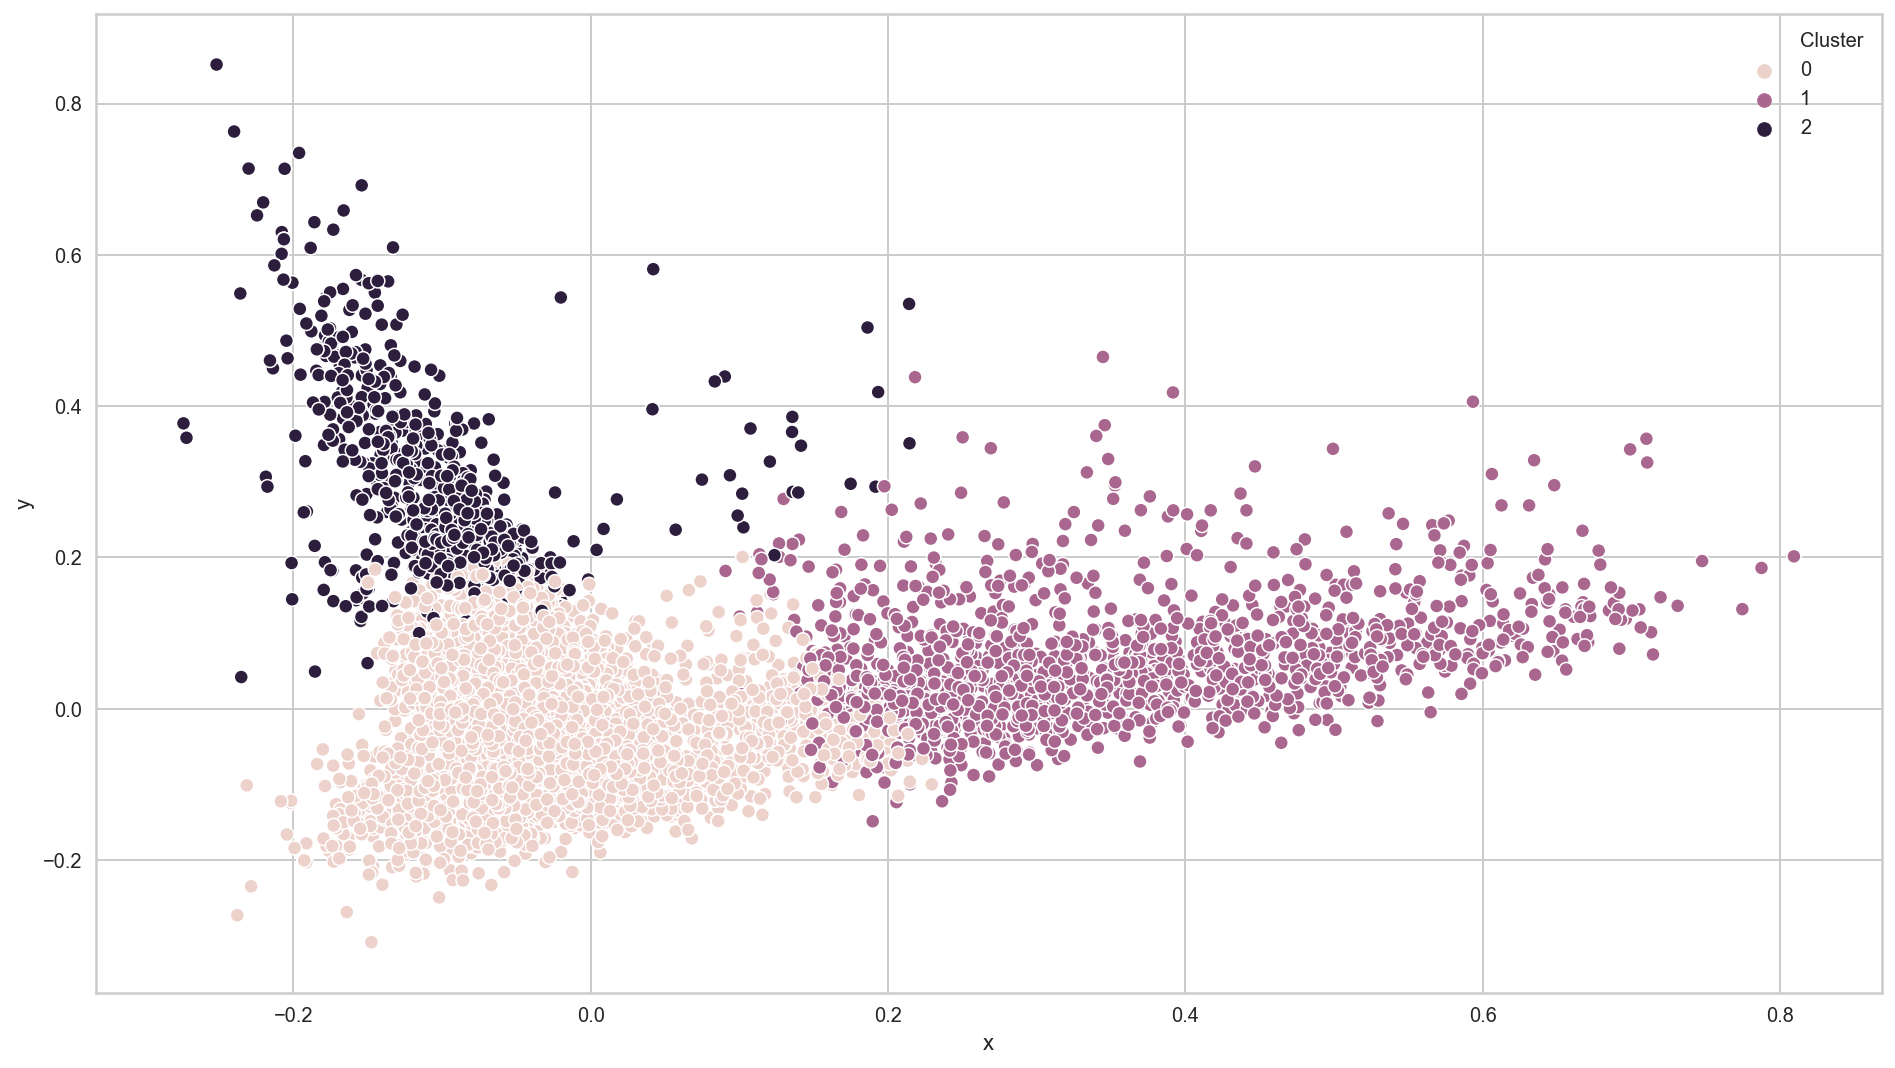

In [22]:
pca_df = pd.DataFrame(dict(x = xs, y = ys, Cluster = clusters ))
plt.subplots(figsize=(16,9))
sns.scatterplot('x', 'y', data=pca_df, hue='Cluster')

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [23]:
# Use LDA for clustering
LDA = LatentDirichletAllocation(n_components=3)

In [24]:
# Term frequency for LDA model
tf_lda = CountVectorizer(
    max_df=0.99,
    max_features=500,
    min_df=0.01,
    tokenizer=tokenization_and_stemming,
    ngram_range=(1,1))


tf_matrix_lda = tf_lda.fit_transform(data) 


print ("In total, there are {} reviews and {} terms.".format(
    str(tf_matrix_lda.shape[0]), str(tf_matrix_lda.shape[1])
))

In total, there are 15000 reviews and 445 terms.


In [25]:
print(tf_matrix_lda.shape)

(15000, 445)


In [26]:
# Feature names
lda_feature_name = tf_lda.get_feature_names()

In [27]:
# Document topic matrix for tf_matrix_lda
lda_output = LDA.fit_transform(tf_matrix_lda)
print(lda_output.shape)

(15000, 3)


In [28]:
# Topics and words matrix
# Components_[i, j] can be viewed as pseudocount that represents the number of times word j was assigned to topic i.
topic_word = LDA.components_
print(topic_word.shape)

(3, 445)


In [29]:
# Column names
topic_names = ["Topic" + str(i) for i in range(LDA.n_components)]

# Index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# Get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,topic
Doc0,0.75,0.23,0.01,0
Doc1,0.79,0.04,0.16,0
Doc2,0.11,0.88,0.01,1
Doc3,0.95,0.02,0.03,0
Doc4,0.97,0.02,0.02,0
Doc5,0.33,0.48,0.19,1
Doc6,0.52,0.13,0.35,0
Doc7,0.48,0.49,0.03,1
Doc8,0.02,0.95,0.03,1
Doc9,0.64,0.33,0.03,0


In [30]:
df_document_topic['topic'].value_counts().to_frame()

,topic
2,5533
0,5478
1,3989


The cluster size is more even in this case.

In [31]:
# Topic-word matrix
df_topic_words = pd.DataFrame(LDA.components_)

# Column and index
df_topic_words.columns = tf_lda.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head()

,abl,absolut,accur,actual,adjust,advertis,ago,alarm,almost,alreadi,...,women,wore,work,worn,worth,would,wrist,wrong,year,yet
Topic0,162.543364,160.717966,28.893088,87.010639,36.932329,15.189714,259.233996,0.370564,136.788735,243.412807,...,47.373512,274.403581,2172.071511,163.298610,251.509245,1130.238884,215.988093,136.972321,1240.301625,118.215664
Topic1,25.329756,44.923534,221.400551,239.407167,129.827761,163.427593,35.490527,0.939582,88.926291,53.353420,...,15.554201,5.700975,512.005305,89.414305,285.564113,966.313557,58.158623,121.692383,228.675000,136.569037
Topic2,155.126880,4.358500,156.706361,249.582195,489.239911,52.382693,2.275477,433.689854,201.284974,63.233773,...,120.072287,5.895444,507.923184,87.287085,47.926642,881.447559,1777.853284,6.335296,139.023376,69.215299


In [32]:
# Print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # For each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tf_lda, lda_model=LDA, n_words=20)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,watch,love,one,work,time,batteri,band,bought,year,replac,day,would,get,look,wear,month,got,back,great,return
Topic 1,br,watch,look,good,price,time,qualiti,one,veri,like,product,would,great,get,case,cheap,day,buy,amazon,made
Topic 2,watch,veri,look,band,like,nice,wrist,time,face,light,small,use,read,big,easi,littl,good,color,size,would


In [34]:
df_document_topic["star_rating"] = df.star_rating.values

In [35]:
df_document_topic.groupby('topic')['star_rating'].value_counts()

topic  star_rating
0      1              1715
       2              1149
       5              1092
       3               822
       4               700
1      5               907
       4               808
       3               774
       1               758
       2               742
2      4              1492
       3              1404
       2              1109
       5              1001
       1               527
Name: star_rating, dtype: int64

From the result above, it seems that topic 0 is more like a negative review topic. We also see words like "replace" and "return" score very high in the output.
Both topic 1 and 2 seem to be kind of positive.

# Part 6: Discussion

In this project, I tried out both K-means and LDA as examples of clustering and topic modeling.

K-means has some limitations. It is very sensitive to outliers. As you may have already seen, it can produce very small clusters corresponding to outliers. And K-means also has difficulties with clusters of different sizes and densities. That is why I randomly select equal size subsets of different star ratings reviews from the whole dataset.

Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. The LDA model is highly modular and can, therefore, be easily extended. The main field of interest is modeling relations between topics. In this task, LDA did a better job of clustering the reviews.